Install neccesary libraries

In [1]:
!pip install openmim
!mim install 'mmcv >= 2.0.0rc1'

# Install mmseg
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
!cd mmsegmentation && pip install -e .

# Install mmdet
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection && pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.7/451.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 19.0 MB/s eta 0:00:00
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmsegmentation
    Found existing installation: mmsegmentation 1.2.2
    Uninstalling mmsegmentation-1.2.2:
      Successfully uninstalled mmsegmentation-1.2.2
  Running setup.py develop for mmsegmentation
fatal: destination path 'mmdetection' already exists and is not an empty directory.
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmdet
    Found existing installation: mmdet 3.3.0
    Uninstalling mmdet-3.3.0:
 

In [3]:
!pip install ftfy

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
%cd /content/mmdetection
import mmdet
print(mmdet.__version__)

# Check MMSegmentation installation
# active directory after this cell will be mmsegmentation
%cd /content/mmsegmentation
import mmseg
print(mmseg.__version__)

2.1.0+cu121 True
/content/mmdetection
3.3.0
/content/mmsegmentation
1.2.2


ade20k folder should be present, i used 100 images and 100 labels from ade20k dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/My Drive/ade20k" "/content/ade20k"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [4]:
from PIL import Image
import os
import shutil
import pandas as pd
import ast
import mmengine
from PIL import Image
import os.path as osp
import numpy as np
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
from mmengine import Config
import matplotlib.pyplot as plt
%matplotlib inline
from mmengine.runner import Runner
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt

Crop images to 512x512

In [12]:
def crop_images(input_folder, output_folder, target_size):
  # Create the output folder if it doesn't exist
  os.makedirs(output_folder, exist_ok=True)

  # Iterate over each file in the input folder
  for file_name in os.listdir(input_folder):
      input_path = os.path.join(input_folder, file_name)
      output_path = os.path.join(output_folder, file_name)

      # Check if the file is an image (you can customize the list of supported extensions)
      if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
          # Open the image
          image = Image.open(input_path)
          # Check if the image needs cropping
          if image.size[0] > target_size[0] or image.size[1] > target_size[1]:
              # Calculate the cropping box to center the image
              left = (image.size[0] - target_size[0]) / 2
              top = (image.size[1] - target_size[1]) / 2
              right = (image.size[0] + target_size[0]) / 2
              bottom = (image.size[1] + target_size[1]) / 2

              # Crop the image
              cropped_image = image.crop((left, top, right, bottom))
              # Save the cropped image to the output folder
              cropped_image.save(output_path)

target_size = (512, 512)
crop_images('/content/ade20k/images', '/content/ade20k/images', target_size)
crop_images('/content/ade20k/labels', '/content/ade20k/labels', target_size)


Count number of images and masks

In [13]:
def count_files_in_folder(folder_path):
    # Use os.listdir to get the list of files in the folder
    files = os.listdir(folder_path)

    # Use len to get the count of files
    file_count = len(files)

    return file_count

folder_path_images = '/content/ade20k/images'
folder_path_labels = '/content/ade20k/labels'

# Call the function to count the files in the folder
num_files_images = count_files_in_folder(folder_path_images)
num_files_labels = count_files_in_folder(folder_path_labels)

# Print the result
print(f'The number of files in {folder_path_images} is: {num_files_images}')
print(f'The number of files in {folder_path_labels} is: {num_files_labels}')


The number of files in /content/ade20k/images is: 100
The number of files in /content/ade20k/labels is: 100


color_coding_semantic_segmentation_classes.csv used for loading classes palette

In [14]:
df = pd.read_csv('/content/color_coding_semantic_segmentation_classes.csv')
class_names = df['Name'].values
classes = ()
for cn in class_names:
    classes += (cn.split(';')[0],)

palletes_names = df['Color_Code (R,G,B)'].values

# Function to convert a string representation of a tuple to a list
def convert_string_to_list(string_tuple):
    tuple_object = ast.literal_eval(string_tuple)
    return list(tuple_object)

# Use the function to convert each string in the array
palette = [convert_string_to_list(s) for s in palletes_names]

Create loader

In [15]:
@DATASETS.register_module()
class Ade20KDataset(BaseSegDataset):
  METAINFO = dict(classes=classes, palette=palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)


In [16]:
data_root = '/content/ade20k'
img_dir = 'images'
ann_dir = 'labels'

Load palette

In [17]:
# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.png'):
  seg_img = Image.open(osp.join(data_root, ann_dir, file)).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file))

Create train i val splits

In [18]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

Download pretrained model and configuration

In [19]:
# Download config and checkpoint files
!mim download mmsegmentation --config mask2former_r50_8xb2-160k_ade20k-512x512 --dest .

processing mask2former_r50_8xb2-160k_ade20k-512x512...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 MiB 13.9 MB/s eta 0:00:00
Successfully downloaded mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth to /content/mmsegmentation
Successfully dumped mask2former_r50_8xb2-160k_ade20k-512x512.py to /content/mmsegmentation


Move images to workdir folder

In [20]:
if os.path.exists('/content/mmsegmentation/ade20k'):
  shutil.rmtree('/content/mmsegmentation/ade20k')

# Source and destination folder paths
source_folder = '/content/ade20k'
destination_folder = '/content/mmsegmentation'

# Use shutil.move to move the entire folder
shutil.move(source_folder, destination_folder)

'/content/mmsegmentation/ade20k'

In [21]:
data_root = 'ade20k'

Create configuration for training

In [22]:
cfg = Config.fromfile('configs/mask2former/mask2former_r50_8xb2-160k_ade20k-512x512.py')

# Load the pretrained weights
cfg.load_from = 'mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth'

# Set up working dir to save files and logs
cfg.work_dir = './work_dirs/tutorial'

cfg.crop_size = (512, 512)  # Change this: desired crop size
cfg.model.data_preprocessor.size = cfg.crop_size

# Change this: set number of classes
cfg.model.decode_head.num_classes = 150
cfg.num_classes = 150

cfg.dataset_type = 'Ade20KDataset'  # Name of the dataset you want to use
cfg.data_root = data_root # Directory in which you have images/ and labels/ folders

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'  # file names for train set
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline


cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'  # file names for val set
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline

cfg.test_dataloader = cfg.val_dataloader

cfg.train_cfg.max_iters = 100
cfg.train_cfg.val_interval = 100
cfg.default_hooks.logger.interval = 5
cfg.default_hooks.checkpoint.interval = 100

cfg['randomness'] = dict(seed=0)

weights = [1.0] * cfg.num_classes
weights.append(0.1) # Expected if you look at original config, need 0.1 as last item
cfg.model.decode_head.loss_cls["class_weight"] = weights

print(f'Config:\n{cfg.pretty_text}')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = 'ade20k'
dataset_type = 'Ade20KDataset'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=100, save_best='mIoU', type='CheckpointHook'),
    logger=dict(interval=5, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi = dict(decay_mult=0.0,

Run training

In [23]:
runner = Runner.from_cfg(cfg)
runner.train()

03/11 19:02:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.2, V12.2.140
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-genc

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
03/11 19:02:53 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
03/11 19:02:53 - mmengine - INF

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


03/11 19:02:55 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth
03/11 19:02:56 - mmengine - INFO - Load checkpoint from mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth
03/11 19:02:56 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
03/11 19:02:56 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
03/11 19:02:56 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/work_dirs/tutorial.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


03/11 19:03:10 - mmengine - INFO - Iter(train) [  5/100]  base_lr: 9.9998e-05 lr: 9.9998e-06  eta: 0:04:09  time: 2.6269  data_time: 0.0142  memory: 10469  grad_norm: 386.6447  loss: 108.9044  decode.loss_cls: 8.9063  decode.loss_mask: 0.6910  decode.loss_dice: 1.2664  decode.d0.loss_cls: 7.9487  decode.d0.loss_mask: 0.8242  decode.d0.loss_dice: 1.6574  decode.d1.loss_cls: 9.5535  decode.d1.loss_mask: 0.8241  decode.d1.loss_dice: 1.3967  decode.d2.loss_cls: 9.0407  decode.d2.loss_mask: 0.7691  decode.d2.loss_dice: 1.3242  decode.d3.loss_cls: 8.9885  decode.d3.loss_mask: 0.7142  decode.d3.loss_dice: 1.2607  decode.d4.loss_cls: 8.8674  decode.d4.loss_mask: 0.7229  decode.d4.loss_dice: 1.2794  decode.d5.loss_cls: 8.8331  decode.d5.loss_mask: 0.7011  decode.d5.loss_dice: 1.3133  decode.d6.loss_cls: 8.6862  decode.d6.loss_mask: 0.6809  decode.d6.loss_dice: 1.2709  decode.d7.loss_cls: 8.7404  decode.d7.loss_mask: 0.6732  decode.d7.loss_dice: 1.2982  decode.d8.loss_cls: 8.6898  decode.d8.loss

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


03/11 19:04:09 - mmengine - INFO - Iter(val) [ 5/20]    eta: 0:00:05  time: 0.3999  data_time: 0.0577  memory: 8960  
03/11 19:04:09 - mmengine - INFO - Iter(val) [10/20]    eta: 0:00:02  time: 0.2342  data_time: 0.0305  memory: 974  
03/11 19:04:10 - mmengine - INFO - Iter(val) [15/20]    eta: 0:00:00  time: 0.0681  data_time: 0.0033  memory: 974  
03/11 19:04:10 - mmengine - INFO - Iter(val) [20/20]    eta: 0:00:00  time: 0.0678  data_time: 0.0029  memory: 974  
03/11 19:04:10 - mmengine - INFO - per class results:
03/11 19:04:10 - mmengine - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|     wall     | 34.01 | 51.03 |
|   building   |  6.92 |  7.03 |
|     sky      | 57.66 | 78.31 |
|    floor     | 82.41 | 84.28 |
|     tree     |  nan  |  nan  |
|   ceiling    | 68.15 | 87.64 |
|     road     |  nan  |  nan  |
|     bed      | 58.74 | 68.51 |
|  windowpane  |  nan  |  nan  |
|    grass     |  0.0  |  nan  |
|   cabinet 

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): _BatchNormXd(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inp

Test model on one image

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_100.pth


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


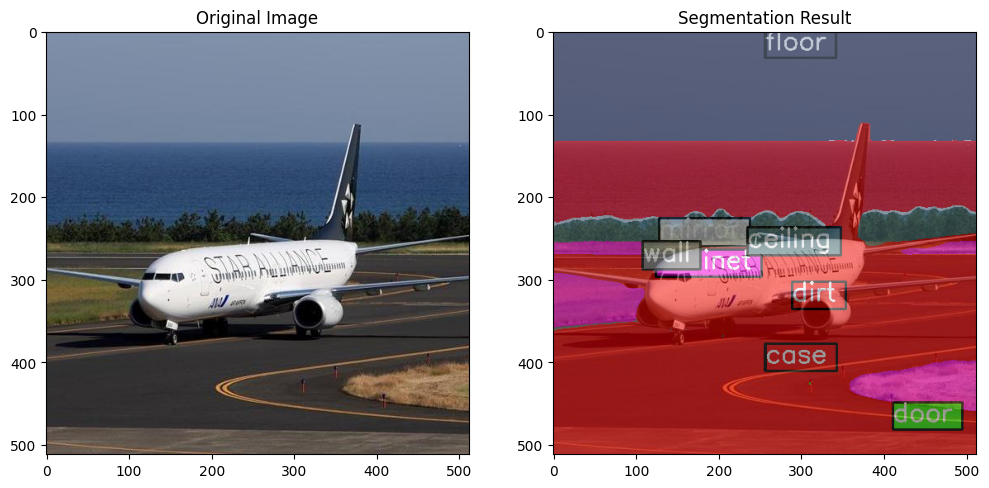

In [24]:
# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_100.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

# Load the original image
img = mmcv.imread('ade20k/images/ADE_train_00014559.jpg')

# Perform inference to get segmentation result
result = inference_model(model, img)

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(12, 6))

# Plot the original image in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(mmcv.bgr2rgb(img))
plt.title('Original Image')

# Plot the segmentation result in the second subplot
plt.subplot(1, 2, 2)
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
plt.title('Segmentation Result')

# Show the subplots
plt.show()
